<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 2: Linear Discriminany Analysis Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[LDA with Simple Features](#lda-simple)  
[LDA with Full Features](#lda-full)  
&nbsp;&nbsp;&nbsp;[Class Weighting](#class-weighting)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Cross Validation](#cross-validation)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the LDA classifier to the Indonesia dataset. As with the Logistic Regression classifier, we will need to deal with the unbalanced classes in the Indonesia dataset to obtain reasonable results. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'lda'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# LDA with simple features <a class="anchor" id="lda-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


In [4]:
# Same method for getting the coefficients as we used with Malawi
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

CPU times: user 39.8 ms, sys: 27.9 ms, total: 67.7 ms
Wall time: 76.3 ms
CPU times: user 60.9 ms, sys: 608 ms, total: 668 ms
Wall time: 47.5 ms
In-sample score: 90.66%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


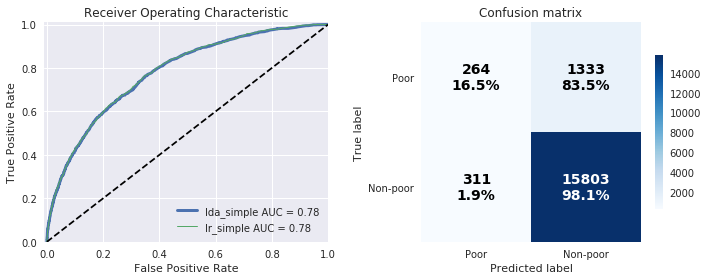

,lda_simple,lr_simple
accuracy,0.907176,0.91158
recall,0.16531,0.0851597
precision,0.45913,0.564315
f1,0.243094,0.147987
cross_entropy,0.26302,0.256817
roc_auc,0.779387,0.781848
cohen_kappa,0.205146,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 3.20% 


In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_columns)

# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train[selected_columns], model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

We can plot the resulting distributions to see how well the classifier separates the classes in the transformed subspace

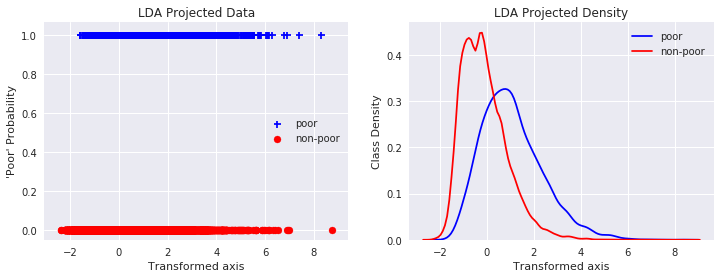

In [6]:
X_lda = model.transform(X_train)

mask = (y_train == 1)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_lda[mask], y_train[mask], color='b', marker='+', label='poor')
axes[0].scatter(X_lda[~mask], y_train[~mask], color='r', marker='o', label='non-poor')
axes[0].set_title('LDA Projected Data')
axes[0].set_xlabel('Transformed axis')
axes[0].set_ylabel('\'Poor\' Probability')
axes[0].legend()

sns.kdeplot(np.ravel(X_lda[mask]), color='b', ax=axes[1], label='poor')
sns.kdeplot(np.ravel(X_lda[~mask]), color='r', ax=axes[1], label='non-poor')
axes[1].set_title('LDA Projected Density')
axes[1].set_xlabel('Transformed axis')
axes[1].set_ylabel('Class Density')
axes[1].legend()
plt.show()

# LDA with all features <a class="anchor" id="all-feats"></a>

Now let's apply the LDA classifier to the dataset with all features.

The Scikit-learn implementation of LDA does not have the option to use sample weights when we fit the model. However, we can apply the sample weights when scoring the model.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 23.6 s, sys: 1min 29s, total: 1min 53s
Wall time: 40.8 s
CPU times: user 122 ms, sys: 648 ms, total: 771 ms
Wall time: 690 ms
In-sample score: 91.06%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


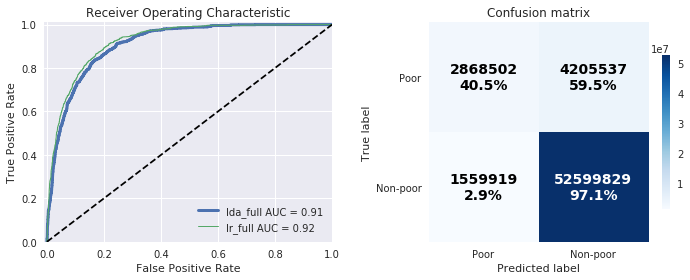

,lda_full,lr_full
accuracy,0.905845,0.910251
recall,0.405497,0.456232
precision,0.647748,0.661838
f1,0.498763,0.540131
cross_entropy,0.231353,0.212947
roc_auc,0.911848,0.923198
cohen_kappa,0.456538,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 7.30% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LinearDiscriminantAnalysis(store_covariance=True)
%time model.fit(X_train, np.ravel(y_train))

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

Once again, the performance is very similar to our Logisitic Regression classifier with all the features. We'll plot the distributions below again as well. We should be able to observe more separation in the class distributions, which results in a higher classifier performance.

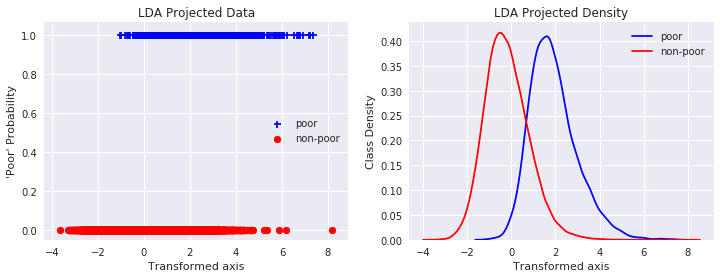

In [8]:
X_lda = model.transform(X_train)

mask = (y_train == 1)
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_lda[mask], y_train[mask], color='b', marker='+', label='poor')
axes[0].scatter(X_lda[~mask], y_train[~mask], color='r', marker='o', label='non-poor')
axes[0].set_title('LDA Projected Data')
axes[0].set_xlabel('Transformed axis')
axes[0].set_ylabel('\'Poor\' Probability')
axes[0].legend()

sns.kdeplot(np.ravel(X_lda[mask]), color='b', ax=axes[1], label='poor')
sns.kdeplot(np.ravel(X_lda[~mask]), color='r', ax=axes[1], label='non-poor')
axes[1].set_title('LDA Projected Density')
axes[1].set_xlabel('Transformed axis')
axes[1].set_ylabel('Class Density')
axes[1].legend()
plt.show()

The class separation looks like we'd expect it, but we still need to deal with the unbalanced classes to improve our predictions of poor households. The LDA model in Scikit-Learn does not allow us to add class-weights as the Logistic Regression model did, so we will need to apply either undersampling or oversampling.

## Class Weighting <a class="anchor" id="class-weighting">
The Scikit-learn LDA model does not have an explicit parameter for class weights, but it does provide a `priors` parameter that serves a similar purpose. We'll input the class proportions as the priors to deal with unbalanced classes.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In-sample score: 52.45%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


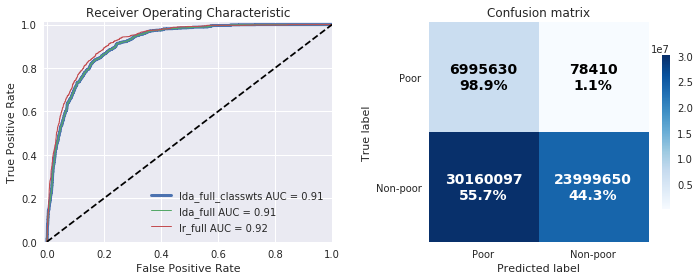

,lda_full_classwts,lda_full,lr_full
accuracy,0.506179,0.905845,0.910251
recall,0.988916,0.405497,0.456232
precision,0.188279,0.647748,0.661838
f1,0.316331,0.498763,0.540131
cross_entropy,1.16564,0.231353,0.212947
roc_auc,0.911848,0.911848,0.923198
cohen_kappa,0.150084,0.456538,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 59.25% 
CPU times: user 27.4 s, sys: 1min 51s, total: 2min 18s
Wall time: 51.6 s


In [9]:
%%time

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = LinearDiscriminantAnalysis(store_covariance=True, 
                                   priors=[y_train.astype(float).sum() / len(y_train), 
                                           (~y_train).astype(float).sum() / len(y_train)])
model.fit(X_train, np.ravel(y_train))

# Get an initial score
score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.coef_[0])

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full',
                                                    'lr_full'],
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Undersampling <a class="anchor" id="undersampling">


X shape after undersampling:  (9584, 453)


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 5.1 s, sys: 37.2 s, total: 42.3 s
Wall time: 13.1 s
CPU times: user 16 ms, sys: 185 ms, total: 201 ms
Wall time: 32.4 ms
In-sample score: 88.50%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


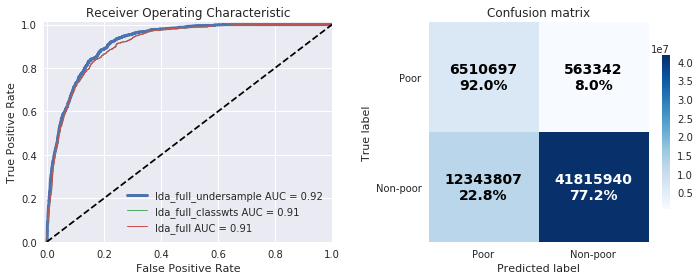

,lda_full_undersample,lda_full_classwts,lda_full
accuracy,0.789215,0.506179,0.905845
recall,0.920365,0.988916,0.405497
precision,0.345313,0.188279,0.647748
f1,0.502203,0.316331,0.498763
cross_entropy,0.484488,1.16564,0.231353
roc_auc,0.92041,0.911848,0.911848
cohen_kappa,0.378004,0.150084,0.456538


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.45% 


In [10]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full_classwts',
                                                    'lda_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CPU times: user 36.5 s, sys: 1min 28s, total: 2min 5s
Wall time: 57 s
CPU times: user 121 ms, sys: 634 ms, total: 755 ms
Wall time: 850 ms
In-sample score: 89.28%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


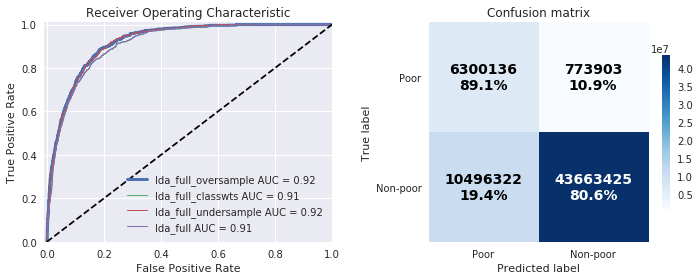

,lda_full_oversample,lda_full_classwts,lda_full_undersample,lda_full
accuracy,0.815948,0.506179,0.789215,0.905845
recall,0.8906,0.988916,0.920365,0.405497
precision,0.375087,0.188279,0.345313,0.647748
f1,0.52786,0.316331,0.502203,0.498763
cross_entropy,0.424324,1.16564,0.484488,0.231353
roc_auc,0.921219,0.911848,0.92041,0.911848
cohen_kappa,0.408593,0.150084,0.378004,0.456538


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.56% 


In [11]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0], index=cols)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full_classwts',
                                                    'lda_full_undersample', 
                                                    'lda_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

## GridSearchCV <a class="anchor" id="grid-search"></a>

As with all of the models we will be building, it is good practice to apply cross validation to avoid overfitting the data. LDA in Scikit-Learn does not have a specific version that performs cross validation. There are, however, other useful modules within Scikit-Learn that are more generalized and allow us to apply this functionality to any classifier. One that we will be using throughout this project is [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This function allows us to tune parameters and conduct cross validation simultaneously. 

When we build a model using this function, we will need to declare the estimator and parameter grid. In the case of LDA, we do not have any model parameters to tune, but there are options for different solvers to use, so we can test each of these out using GridSearchCV to find the one that gives us the best performance.

X shape after oversampling:  (96680, 453)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(

CPU times: user 3min 5s, sys: 10min 4s, total: 13min 10s
Wall time: 5min 44s
CPU times: user 201 ms, sys: 621 ms, total: 822 ms
Wall time: 564 ms
In-sample score: 89.34%
Best model parameters: {'solver': 'svd'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


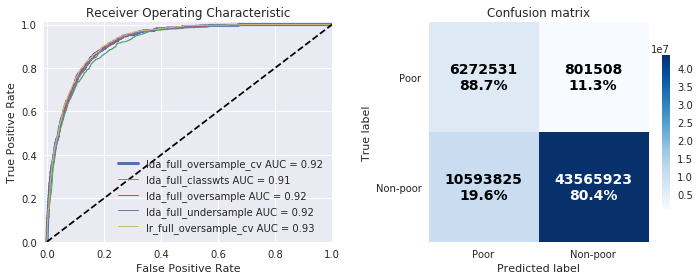

,lda_full_oversample_cv,lda_full_classwts,lda_full_oversample,lda_full_undersample,lr_full_oversample_cv
accuracy,0.813904,0.506179,0.815948,0.789215,0.851611
recall,0.886697,0.988916,0.8906,0.920365,0.838116
precision,0.371896,0.188279,0.375087,0.345313,0.427456
f1,0.524012,0.316331,0.52786,0.502203,0.566159
cross_entropy,0.426183,1.16564,0.424324,0.484488,0.348544
roc_auc,0.92172,0.911848,0.921219,0.92041,0.925356
cohen_kappa,0.406539,0.150084,0.408593,0.378004,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 26.67% 


In [12]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)
X_train = pd.DataFrame(X_train, columns=cols)

# build the model
estimator = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd']}

model = GridSearchCV(estimator, parameters, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full_classwts',
                                                    'lda_full_oversample',
                                                    'lda_full_undersample', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)
X_train_best_model = X_train

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# Feature selection <a class="anchor" id="feature-selection"></a>

In [13]:
def get_corrs_df(X, model):
    X_lda = model.transform(X)
    corrs = []
    for col in X.columns:
        corrs.append(np.corrcoef(np.ravel(X_lda),X[col])[0][1])
    corrs = pd.DataFrame(corrs, columns=['correlation'], index=X.columns)
    corrs['abs'] = corrs.correlation.apply(abs)
    return corrs.sort_values('abs', ascending=False)

In [14]:
corrs = get_corrs_df(X_train, model.best_estimator_)
display(corrs.head(20))
feats = corrs.index.values

,correlation,abs
hld_cooking__Firewood,0.543823,0.543823
hld_refrigerator__Yes,-0.523712,0.523712
cons_254__Yes,0.510001,0.510001
hld_motorcycle__Yes,-0.504780,0.504780
hld_nbcell,-0.500855,0.500855
cons_292__Yes,-0.487436,0.487436
cons_296__Yes,-0.446604,0.446604
cons_266__Yes,-0.443669,0.443669
hld_anycell__Yes,-0.417960,0.417960
cons_212__Yes,-0.416595,0.416595


In [15]:
# initially filter out lowest features
best_model = evaluation.load_model('lda_full_oversample_cv', COUNTRY)
corrs = get_corrs_df(X_train_best_model, best_model['model'])
feats = corrs[corrs['abs'] > 0.15].index.values

# load metrics from our best model
best_model_metrics = evaluation.load_model_metrics('lda_full_oversample_cv', COUNTRY)

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)

# Load and transform the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Iteratively drop features until the f1 score is beneath our threshold
max_score = 0
f1_score = 1
f1_scores = []
f1_threshold = best_model_metrics['f1'] * 0.90

while (f1_score > f1_threshold) & (X_train.shape[1] >= 1):
    # Fit the model
    estimator = LinearDiscriminantAnalysis()
    parameters = {'solver': ['svd']}
    model = GridSearchCV(estimator, parameters).fit(X_train, y_train)
    
    # Get feature correlations
    corrs = get_corrs_df(X_train, model)
    feats = corrs.sort_values('abs', ascending=False).index.values

    # Run the model
    y_pred = model.predict(X_test[X_train.columns])
    y_prob = model.predict_proba(X_test[X_train.columns])[:,1]

    # Evaluate performance
    metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test, show=False)
    
    # Compare f1 score to threshold
    f1_score = metrics['f1']
    if f1_score > max_score:
        max_score = f1_score
        best_feats = X_train.columns
    
    # Drop feature with lowest coefficient
    X_train.drop(feats[-1], axis=1, inplace=True)
    print("n: {}, f1: {}, lowest coef: {}".format(len(feats), metrics['f1'], feats[-1]))
display(corrs)
selected_feats = feats

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 154, f1: 0.5015808475487137, lowest coef: cons_145__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 153, f1: 0.5024924454514307, lowest coef: cons_276__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 152, f1: 0.5013528287342875, lowest coef: cons_180__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 151, f1: 0.5019140703782125, lowest coef: hld_occstat__Rent


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 150, f1: 0.5021729798488014, lowest coef: hld_dwater__Protected spring


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 149, f1: 0.5031035514276561, lowest coef: cons_325__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 148, f1: 0.5025232886238248, lowest coef: cons_002__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 147, f1: 0.5014368373518395, lowest coef: hld_dwateracq__Customer-based


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 146, f1: 0.5003281236329501, lowest coef: geo_province__Papua


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 145, f1: 0.5002103659745528, lowest coef: hld_lighting__Other


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 144, f1: 0.5000252384254147, lowest coef: cons_329__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 143, f1: 0.5001683945861192, lowest coef: hld_disposal__Pit hole


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 142, f1: 0.5012916796095189, lowest coef: cons_185__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 141, f1: 0.5030875171130469, lowest coef: hld_landstat__Freehold title (HM)


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 140, f1: 0.5028415860809395, lowest coef: cons_148__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 139, f1: 0.5011597373473173, lowest coef: hld_bwwater__Unprotected spring


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 138, f1: 0.4991014356231638, lowest coef: hld_bicycle__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 137, f1: 0.49808973598070405, lowest coef: cons_096__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 136, f1: 0.4991484699263032, lowest coef: cons_175__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 135, f1: 0.4976440997759669, lowest coef: cons_022__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 134, f1: 0.5024587338512506, lowest coef: cons_201__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 133, f1: 0.5021673259360262, lowest coef: cons_082__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 132, f1: 0.5017245878448087, lowest coef: cons_228__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 131, f1: 0.5010404610928915, lowest coef: hld_roof__Fiber/palm


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 130, f1: 0.5013464090989157, lowest coef: cons_169__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 129, f1: 0.5003235909891689, lowest coef: der_nemployedpast3mo


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 128, f1: 0.49960412753021444, lowest coef: hld_cabletv__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 127, f1: 0.49995508197943356, lowest coef: cons_054__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 126, f1: 0.5006287584475616, lowest coef: cons_090__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 125, f1: 0.4989483421365305, lowest coef: cons_031__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 124, f1: 0.5002092039416935, lowest coef: cons_218__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 123, f1: 0.5000357156569781, lowest coef: cons_315__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 122, f1: 0.4990345482506347, lowest coef: cons_193__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 121, f1: 0.5002945629534247, lowest coef: hld_aircon__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 120, f1: 0.5013263956482333, lowest coef: cons_081__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 119, f1: 0.5003067651250068, lowest coef: cons_008__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 118, f1: 0.4967813034346082, lowest coef: cons_159__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 117, f1: 0.4978222916921166, lowest coef: cons_109__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 116, f1: 0.4965687878646001, lowest coef: cons_172__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 115, f1: 0.4960572226199083, lowest coef: cons_310__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 114, f1: 0.496236923016407, lowest coef: cons_317__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 113, f1: 0.4967955748493414, lowest coef: cons_235__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 112, f1: 0.49701294569525545, lowest coef: hld_dwater__Pipe with meter


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 111, f1: 0.4975676177681104, lowest coef: cons_095__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 110, f1: 0.49855728871006466, lowest coef: cons_178__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 109, f1: 0.4984352705632139, lowest coef: cons_196__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 108, f1: 0.4984606455510485, lowest coef: cons_284__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 107, f1: 0.4986460101477476, lowest coef: cons_300__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 106, f1: 0.49864216636028347, lowest coef: cons_309__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 105, f1: 0.4963601355950444, lowest coef: hld_bwwater__Terrestrial well/pump


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 104, f1: 0.49636774938369327, lowest coef: cons_267__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 103, f1: 0.4963862568044146, lowest coef: hld_anyphone__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 102, f1: 0.49643617414641145, lowest coef: cons_256__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 101, f1: 0.4962376278417128, lowest coef: hld_floor__Other


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 100, f1: 0.49627458183297957, lowest coef: cons_030__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 99, f1: 0.49437003004902036, lowest coef: cons_210__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 98, f1: 0.4938788766809053, lowest coef: hld_waterheat__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 97, f1: 0.4939240051483846, lowest coef: cons_123__Yes


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


n: 96, f1: 0.49485263147096176, lowest coef: hld_landstat__Not applicable
n: 95, f1: 0.49485263147096176, lowest coef: hld_occstat__Owned
n: 94, f1: 0.4949663697417769, lowest coef: cons_093__Yes
n: 93, f1: 0.49534571505158753, lowest coef: geo_province__East Nusa Tenggara
n: 92, f1: 0.49306489787983226, lowest coef: cons_301__Yes
n: 91, f1: 0.49214015507885245, lowest coef: cons_186__Yes
n: 90, f1: 0.49238439132974104, lowest coef: der_nfemalesover10
n: 89, f1: 0.4930166610408313, lowest coef: cons_130__Yes
n: 88, f1: 0.4927745233902543, lowest coef: hld_dwatershr__Public
n: 87, f1: 0.49119607628813944, lowest coef: geo_district
n: 86, f1: 0.49119607628813944, lowest coef: cons_272__Yes
n: 85, f1: 0.49050047154504206, lowest coef: cons_224__Yes
n: 84, f1: 0.48587560859081685, lowest coef: cons_208__Yes
n: 83, f1: 0.48598712337994865, lowest coef: cons_025__Yes
n: 82, f1: 0.48217560265035275, lowest coef: cons_263__Yes
n: 81, f1: 0.48328438292881454, lowest coef: cons_098__Yes
n: 80, f

,correlation,abs
hld_cooking__Firewood,0.618528,0.618528
hld_refrigerator__Yes,-0.599601,0.599601
cons_254__Yes,0.580805,0.580805
hld_motorcycle__Yes,-0.575712,0.575712
hld_nbcell,-0.562802,0.562802
cons_292__Yes,-0.557538,0.557538
cons_266__Yes,-0.503334,0.503334
cons_296__Yes,-0.503043,0.503043
hld_dwateracq__Not buying,0.485033,0.485033
cons_212__Yes,-0.476497,0.476497


X shape after oversampling:  (96680, 42)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


CPU times: user 8.91 s, sys: 25.9 s, total: 34.8 s
Wall time: 2.26 s
CPU times: user 60.6 ms, sys: 381 ms, total: 442 ms
Wall time: 16.4 ms
In-sample score: 82.82%
Best model parameters: {'solver': 'svd'}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


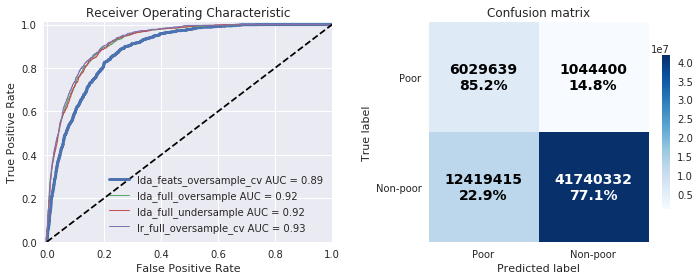

,lda_feats_oversample_cv,lda_full_oversample,lda_full_undersample,lr_full_oversample_cv
accuracy,0.780124,0.815948,0.789215,0.851611
recall,0.852362,0.8906,0.920365,0.838116
precision,0.326826,0.375087,0.345313,0.427456
f1,0.472485,0.52786,0.502203,0.566159
cross_entropy,0.458391,0.424324,0.484488,0.348544
roc_auc,0.885536,0.921219,0.92041,0.925356
cohen_kappa,0.304581,0.408593,0.378004,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.08% 


In [16]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=selected_feats)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
print("X shape after oversampling: ", X_train.shape)
X_train = pd.DataFrame(X_train, columns=cols)

# build the model
estimator = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd']}

model = GridSearchCV(estimator, parameters, cv=5, verbose=1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=selected_feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['lda_full_oversample',
                                                    'lda_full_undersample', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='feats_oversample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

In [17]:
feats = coefs.sort_values('abs', ascending=False).index.values
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

19 consumables features selected:
Gasoline/pertamax
Clothes maintenance material
Other drinks (coffee, milk, etc) 
Broiler egg
Ready-made clothes for women
Ready-made clothes for men
Orange
Potato
Lubricant
Broiler meat
LPG Value
Noodle (with meatball/boiled/fried)
Soya sauce
Mineral water (gallon)
Motor and non-motor vehicle taxes
Other stuffs (tissue, baby diaper, satai stick, etc.)
Firewood and other fuels
Motor vehicle's service and repair
Mobile phone bill


This feature selection process does not appear to be as effective as the ones we applied with Linear Regression. We may lose more performance in the case of the Indonesia dataset if we want to use this method to create a smaller set of questions.

# LDA Indonesia Summary <a class="anchor" id="summary"></a>



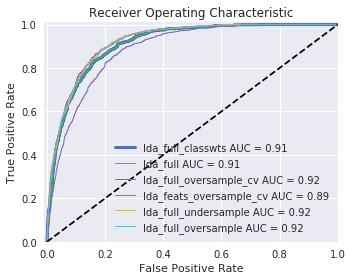

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
lda_full_classwts,0.506179,0.988916,0.188279,0.316331,1.16564,0.911848,0.150084,0.478668
lda_full,0.905845,0.405497,0.647748,0.498763,0.231353,0.911848,0.456538,-0.0408086
lda_full_oversample_cv,0.813904,0.886697,0.371896,0.524012,0.426183,0.92172,0.406539,0.152916
lda_feats_oversample_cv,0.780124,0.852362,0.326826,0.472485,0.458391,0.885536,0.304581,0.177014
lda_full_undersample,0.789215,0.920365,0.345313,0.502203,0.484488,0.92041,0.378004,0.180678
lda_full_oversample,0.815948,0.8906,0.375087,0.52786,0.424324,0.921219,0.408593,0.151802


In [18]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)